In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import plotly.express as px

In [2]:
ads_clients_data = pd.read_csv('C:/Users/askha/Downloads/ads/ads_clients_data.csv')
ads_data = pd.read_csv('C:/Users/askha/Downloads/ads/ads_data.csv')

In [3]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [4]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.

In [5]:
ads_data.groupby(['ad_id', 'event'], as_index=False)  \
    .agg({'platform' : 'count'}) \
    .pivot(index='ad_id', columns='event', values='platform').reset_index() \
    .fillna(0) \
    .mean() \
    .round()

event
ad_id    57971.0
click      113.0
view       923.0
dtype: float64

Давайте посмотрим на распределение показов объявлений!

По оси x – число показов
По оси y – доля объявлений с такими показами
Прологарифмируйте число показов, а затем постройте такой график, чтобы можно было понять форму распределения. 

In [6]:
views = ads_data.query('event == "view"') \
    .groupby(['ad_id'], as_index=False) \
    .agg({'event' : 'count'}) \
    .fillna(0)

In [7]:
views_log = np.log(views.event)

In [8]:
ads_data.event.unique()

array(['view', 'click'], dtype=object)

In [9]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='event'>

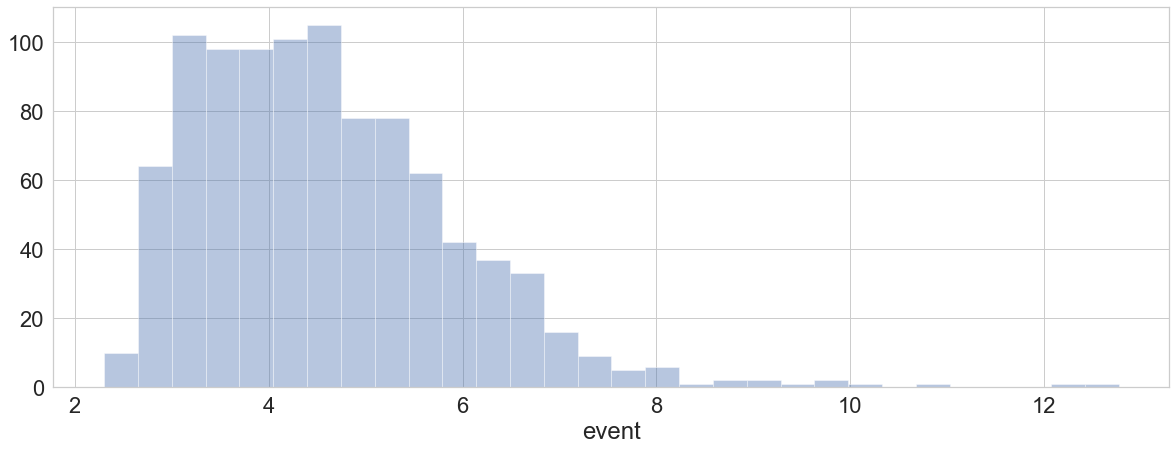

In [10]:
sns.distplot(views_log, kde=False)

Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

In [11]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [12]:
ads_data.query('event == "view"') \
    .groupby(['date', 'ad_id'])  \
    .agg({'event' : 'count'}) \
    .groupby('date') \
    .agg({'event' : 'mean'}) \
    .rolling(2).mean() \
    .round()

,event
date,
2019-04-01,NaN
2019-04-02,146.0
2019-04-03,151.0
2019-04-04,420.0
2019-04-05,798.0
2019-04-06,598.0


In [13]:
ads_views_by_date = ads_data.query('event == "view"') \
    .pivot_table(index='ad_id',
                columns='date',
                values='time',
                aggfunc='count')

In [14]:
mean_ads_views = ads_views_by_date.mean()

In [15]:
rolling_ads_views = mean_ads_views.rolling(2).mean()

Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd

<AxesSubplot:xlabel='date'>

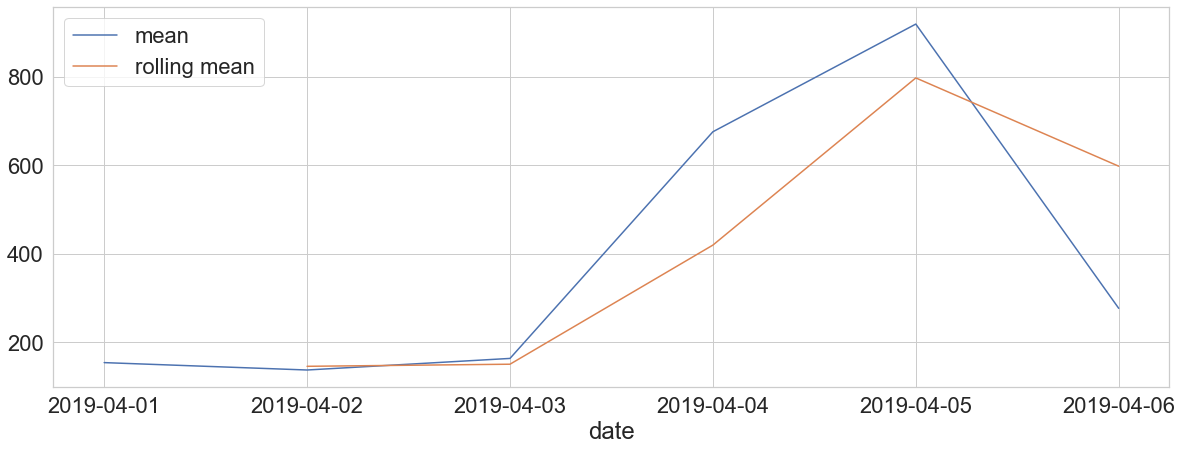

In [16]:
sns.lineplot(data=mean_ads_views, label='mean')
sns.lineplot(data=rolling_ads_views, label='rolling mean')

In [17]:
mean_ads_views

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [18]:
rolling_ads_views

date
2019-04-01           NaN
2019-04-02    146.134626
2019-04-03    150.869880
2019-04-04    419.927249
2019-04-05    797.505699
2019-04-06    598.116202
dtype: float64

In [19]:
(mean_ads_views - rolling_ads_views).abs()

date
2019-04-01           NaN
2019-04-02      8.347644
2019-04-03     13.082898
2019-04-04    255.974471
2019-04-05    121.603979
2019-04-06    320.993475
dtype: float64

Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

В качестве ответа укажите среднее число дней.

In [20]:
ads_data

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501
...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-05,2019-04-05 20:59:52,view,web,112583,111818,112260,CPM,210.1,0,22392
999996,2019-04-05,2019-04-05 20:59:52,view,android,112583,111818,112260,CPM,210.1,0,22392
999997,2019-04-05,2019-04-05 20:59:52,click,web,112583,111818,112260,CPM,210.1,0,22392
999998,2019-04-05,2019-04-05 20:59:52,view,web,113350,113036,113251,CPM,183.3,0,571929


In [21]:
ads_all = ads_data.merge(ads_clients_data, how='inner', on='client_union_id')

In [22]:
ads_all

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-04,2019-04-04 18:07:25,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999996,2019-04-04,2019-04-04 18:29:06,view,ios,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999997,2019-04-04,2019-04-04 18:55:46,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999998,2019-04-04,2019-04-04 19:21:09,view,android,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04


In [23]:
ads_all.dtypes

date_x                    object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
date_y                    object
community_id               int64
create_date               object
dtype: object

In [24]:
ads_all[['date_x', 'create_date']] = ads_all[['date_x', 'create_date']].apply(pd.to_datetime)

In [25]:
ads_all.groupby('client_union_id') \
    .apply(lambda group: (group.date_x - group.create_date).min()) \
    .mean() # this is a more elegant solve than the one below

Timedelta('124 days 09:04:43.532219570')

In [26]:
ads_all['days_before_add_creation'] = ads_all.date_x.subtract(ads_all.create_date)

In [27]:
ads_all

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,days_before_add_creation
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-04,2019-04-04 18:07:25,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999996,2019-04-04,2019-04-04 18:29:06,view,ios,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999997,2019-04-04,2019-04-04 18:55:46,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999998,2019-04-04,2019-04-04 19:21:09,view,android,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days


In [28]:
ads_all.groupby('client_union_id') \
    .agg({'days_before_add_creation' : "min"}) \
    .mean()

days_before_add_creation   124 days 09:04:43.532219570
dtype: timedelta64[ns]

Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. В таком случае конверсия будет равна

1000
50
​
 ∗100=5%

Чтобы отобрать данные за нужный промежуток, можно воспользоваться сравнением времени до создания первой рекламы с pd.Timedelta(365, unit='day'))

In [29]:
year

NameError: name 'year' is not defined

In [ ]:
ads_all.groupby('client_union_id') \
    .apply(lambda group: (group.date_x - group.create_date).min())

In [ ]:
creation_difference = ads_all.groupby('client_union_id') \
    .apply(lambda group: (group.date_x - group.create_date).min())

In [ ]:
creation_difference = creation_difference.loc[creation_difference < year]

In [ ]:
all_clients = ads_clients_data.client_union_id.shape[0]

In [ ]:
round(creation_difference.shape[0] / all_clients * 100, 2)

Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. Создать временные промежутки можно с помощью pd.to_timedelta().

In [32]:
bins = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d'])

In [33]:
ads_all['categorical_days_creation'] = pd.cut(ads_all.days_creation, bins=bins, labels=["less than 30 day", 
                                                                   "30-90 days", "90-180 days", 
                                                                   "more than 365 days"])


AttributeError: 'DataFrame' object has no attribute 'days_creation'

In [ ]:
ads_all.categorical_days_creation.value_counts()

И последнее задание: постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них (то, что у вас получилось на прошлом степе, по запуску первого рекламного объявления). Расположите их так, чтобы внизу была самая малочисленная, а наверху – самая большая.

In [31]:
viz = ads_all.groupby('categorical_days_creation',as_index=False) \
    .agg({'client_union_id' : 'count'}) \
    .rename(columns={"client_union_id": "Count"}) \
    .sort_values('Count', ascending=False)

KeyError: 'categorical_days_creation'

In [ ]:
viz

In [30]:
fig = px.bar(viz, x='categorical_days_creation', y='Count')
fig.show()

NameError: name 'viz' is not defined